In [2]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from seqeval.metrics import classification_report, precision_score
from IPython.display import HTML

from model import BiLSTM_CRF
from dataset import io2df, io2bio, padding, NERDataset
from utils import Config, load_ner_config
from visualisation import highlight_entities, plot_classification_report
from typing import List, Dict

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [3]:
config = Config('config.yaml')
config.__dict__

{'TR_PATH': 'data/supervised/train.txt',
 'VA_PATH': 'data/supervised/dev.txt',
 'TE_PATH': 'data/supervised/test.txt',
 'SEQ_LEN': 100,
 'BATCH_SIZE': 128,
 'LR': 0.0005,
 'REG_LAMBDA': 0.001,
 'REG_ALPHA': 0.5,
 'MAX_GRAD_NORM': 100,
 'NUM_EPOCHS': 10,
 'EMBED_SIZE': 100,
 'HIDDEN_SIZE': 256,
 'DROPOUT': 0.5}

In [4]:
te_titles = io2df(config.TE_PATH)

100%|██████████| 958765/958765 [00:01<00:00, 785539.35it/s]


In [5]:
TAG2IDX = load_ner_config('ner_tags/ner_coarse_grained.json')
IDX2TAG = {i: t for t, i in TAG2IDX.items()}

TKN2IDX = load_ner_config('tokenizers/token2idx.json')
IDX2TKN = {i: t for t, i in TKN2IDX.items()}

In [6]:
# encode
te_titles['tags_ids'] = te_titles['tags_coarse_grained'].transform(lambda x: [TAG2IDX[tag] for tag in x])
te_titles['tokens_ids'] = te_titles['tokens'].transform(lambda x: [TKN2IDX[token] if token in TKN2IDX else TKN2IDX['UKN'] for token in x])

# padding
te_titles['tokens_ids'] = te_titles['tokens_ids'].transform(padding, max_len=config.SEQ_LEN)
te_titles['tags_ids'] = te_titles['tags_ids'].transform(padding, max_len=config.SEQ_LEN)

In [7]:
te_titles

,id,tokens,tags_fine_grained,tags_coarse_grained,tags_ids,tokens_ids
0,0,"[In, the, early, 1930s, the, band, moved, to, ...","[O, O, O, O, O, O, O, O, O, building-other, bu...","[O, O, O, O, O, O, O, O, O, building, building...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, ...","[25, 2, 166, 2825, 2, 277, 246, 8, 2, 7432, 39..."
1,1,"[The, final, season, of, minor, league, play, ...","[O, O, O, O, O, O, O, location-park, location-...","[O, O, O, O, O, O, O, location, location, loca...","[1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, ...","[12, 288, 81, 5, 1541, 567, 267, 30529, 782, 1..."
2,2,"[They, finished, the, season, 14–19, ,, 9–9, i...","[O, O, O, O, O, O, O, O, event-sportsevent, ev...","[O, O, O, O, O, O, O, O, event, event, O, O, O...","[1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, ...","[198, 528, 2, 81, 1, 3, 44681, 7, 22858, 267, ..."
3,3,"[The, B-52, pilot, ,, Major, Larry, G., Messin...","[O, product-other, O, O, O, person-other, pers...","[O, product, O, O, O, person, person, person, ...","[1, 9, 1, 1, 1, 8, 8, 8, 1, 1, 1, 1, 0, 0, 0, ...","[12, 15859, 1689, 3, 1122, 3247, 3210, 1, 3, 7..."
4,4,"[The, Austro-Hungarian, Navy, built, and, oper...","[O, organization-other, organization-other, O,...","[O, organization, organization, O, O, O, O, O,...","[1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[12, 15069, 675, 178, 6, 445, 50, 2480, 5, 359..."
...,...,...,...,...,...,...
37643,37643,"[The, remaining, 25, were, scrapped, in, 1959, .]","[O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[12, 1448, 453, 30, 9933, 7, 1423, 4, 0, 0, 0,..."
37644,37644,"[Lady, Forester, died, in, 1922, .]","[O, person-other, O, O, O, O]","[O, person, O, O, O, O]","[1, 8, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2162, 1, 278, 7, 2376, 4, 0, 0, 0, 0, 0, 0, 0..."
37645,37645,"[As, all, aminopenicillins, ,, amoxicillin, ha...","[O, O, other-chemicalthing, O, other-chemicalt...","[O, O, other, O, other, O, O, O, O, other, oth...","[1, 1, 7, 1, 7, 1, 1, 1, 1, 7, 7, 1, 7, 7, 7, ...","[191, 95, 1, 3, 28054, 38, 47, 818, 20, 46629,..."
37646,37646,"[The, Storm, Prediction, Center, in, Oklahoma,...","[O, organization-other, organization-other, or...","[O, organization, organization, organization, ...","[1, 6, 6, 6, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12, 4050, 1, 222, 7, 2443, 40, 1282, 2, 4180,..."


In [8]:
te_dataset = NERDataset(te_titles)
te_dataloader = DataLoader(dataset=te_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)

te_dataset.__getitem__(123)

{'tokens_ids': tensor([ 3474,    48,    96,   115,   158,     3,    29,  1209,     9,  3190,
             5,   557,     7, 17140,     6,  2211,    34,     8,     2,   324,
          1231,   313,     3, 23582,     1,     3,    16,     2,   284,     5,
             9,  1597,     4,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'tags_ids': tensor([1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6,
         6, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0,

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = BiLSTM_CRF(
    embed_size     = config.EMBED_SIZE,
    hidden_size    = config.HIDDEN_SIZE, 
    dropout        = config.DROPOUT,
    token_voc_size = len(TKN2IDX), 
    tag_voc_size   = len(TAG2IDX),
).to(device)

token_embedding.weight         initialized w with Xavier            parameters #: 5000200
lstm.weight_ih_l0              initialized w with Xavier            parameters #: 51200
lstm.weight_hh_l0              initialized w with Xavier            parameters #: 65536
lstm.bias_ih_l0                initialized b with zero              parameters #: 512
lstm.bias_hh_l0                initialized b with zero              parameters #: 512
lstm.weight_ih_l0_reverse      initialized w with Xavier            parameters #: 51200
lstm.weight_hh_l0_reverse      initialized w with Xavier            parameters #: 65536
lstm.bias_ih_l0_reverse        initialized b with zero              parameters #: 512
lstm.bias_hh_l0_reverse        initialized b with zero              parameters #: 512
fc.weight                      initialized w with Xavier            parameters #: 2560
fc.bias                        initialized b with zero              parameters #: 10
crf.start_transitions          initialized

In [10]:
state_dict = torch.load(f='artefacts/coarse_grained/weights/model_epoch_04.pt', map_location=torch.device(device))
model.load_state_dict(state_dict=state_dict)
model.eval()

BiLSTM_CRF(
  (token_embedding): Embedding(50002, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (crf): CRF(num_tags=10)
)

In [11]:
batch_trues = []
batch_preds = []

for va_batch in tqdm(te_dataloader, total=te_dataloader.__len__()):
    te_xs = va_batch['tokens_ids'].to(device)
    te_ys = va_batch['tags_ids'].to(device)

    te_emission_scores = model(te_xs).to(device)
    te_preds = torch.tensor(model.decode(te_emission_scores))

    mask = (te_ys > 0).bool()
    
    for row_id, true in enumerate(te_ys):
        # do not count padding
        true_tags = true[mask[row_id]]
        # idx2tag
        true_tags = [IDX2TAG[idx] for idx in true_tags.tolist()]
        # convert to the format expected by seqeval
        true_tags = io2bio(true_tags)
        batch_trues.append(true_tags)

    for row_id, pred in enumerate(te_preds):
        # do not count padding
        pred_tags = pred[mask[row_id]]
        # idx2tag
        pred_tags = [IDX2TAG[idx] for idx in pred_tags.tolist()]
        # convert to the format expected by seqeval
        pred_tags = io2bio(pred_tags)
        batch_preds.append(pred_tags)

report = classification_report(y_true=batch_trues, y_pred=batch_preds, zero_division=0)
print(report)

  0%|          | 0/295 [00:00<?, ?it/s]

/Users/artemmerinov/PycharmProjects/NER/.venv/lib/python3.10/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 295/295 [01:12<00:00,  4.07it/s]


              precision    recall  f1-score   support

         art       0.69      0.65      0.67      4059
    building       0.60      0.60      0.60      5004
       event       0.61      0.52      0.56      4101
    location       0.73      0.80      0.77     27213
organization       0.63      0.58      0.60     19068
       other       0.65      0.39      0.49      9557
      person       0.80      0.80      0.80     21500
     product       0.55      0.45      0.49      6228

   micro avg       0.70      0.67      0.68     96730
   macro avg       0.66      0.60      0.62     96730
weighted avg       0.69      0.67      0.68     96730



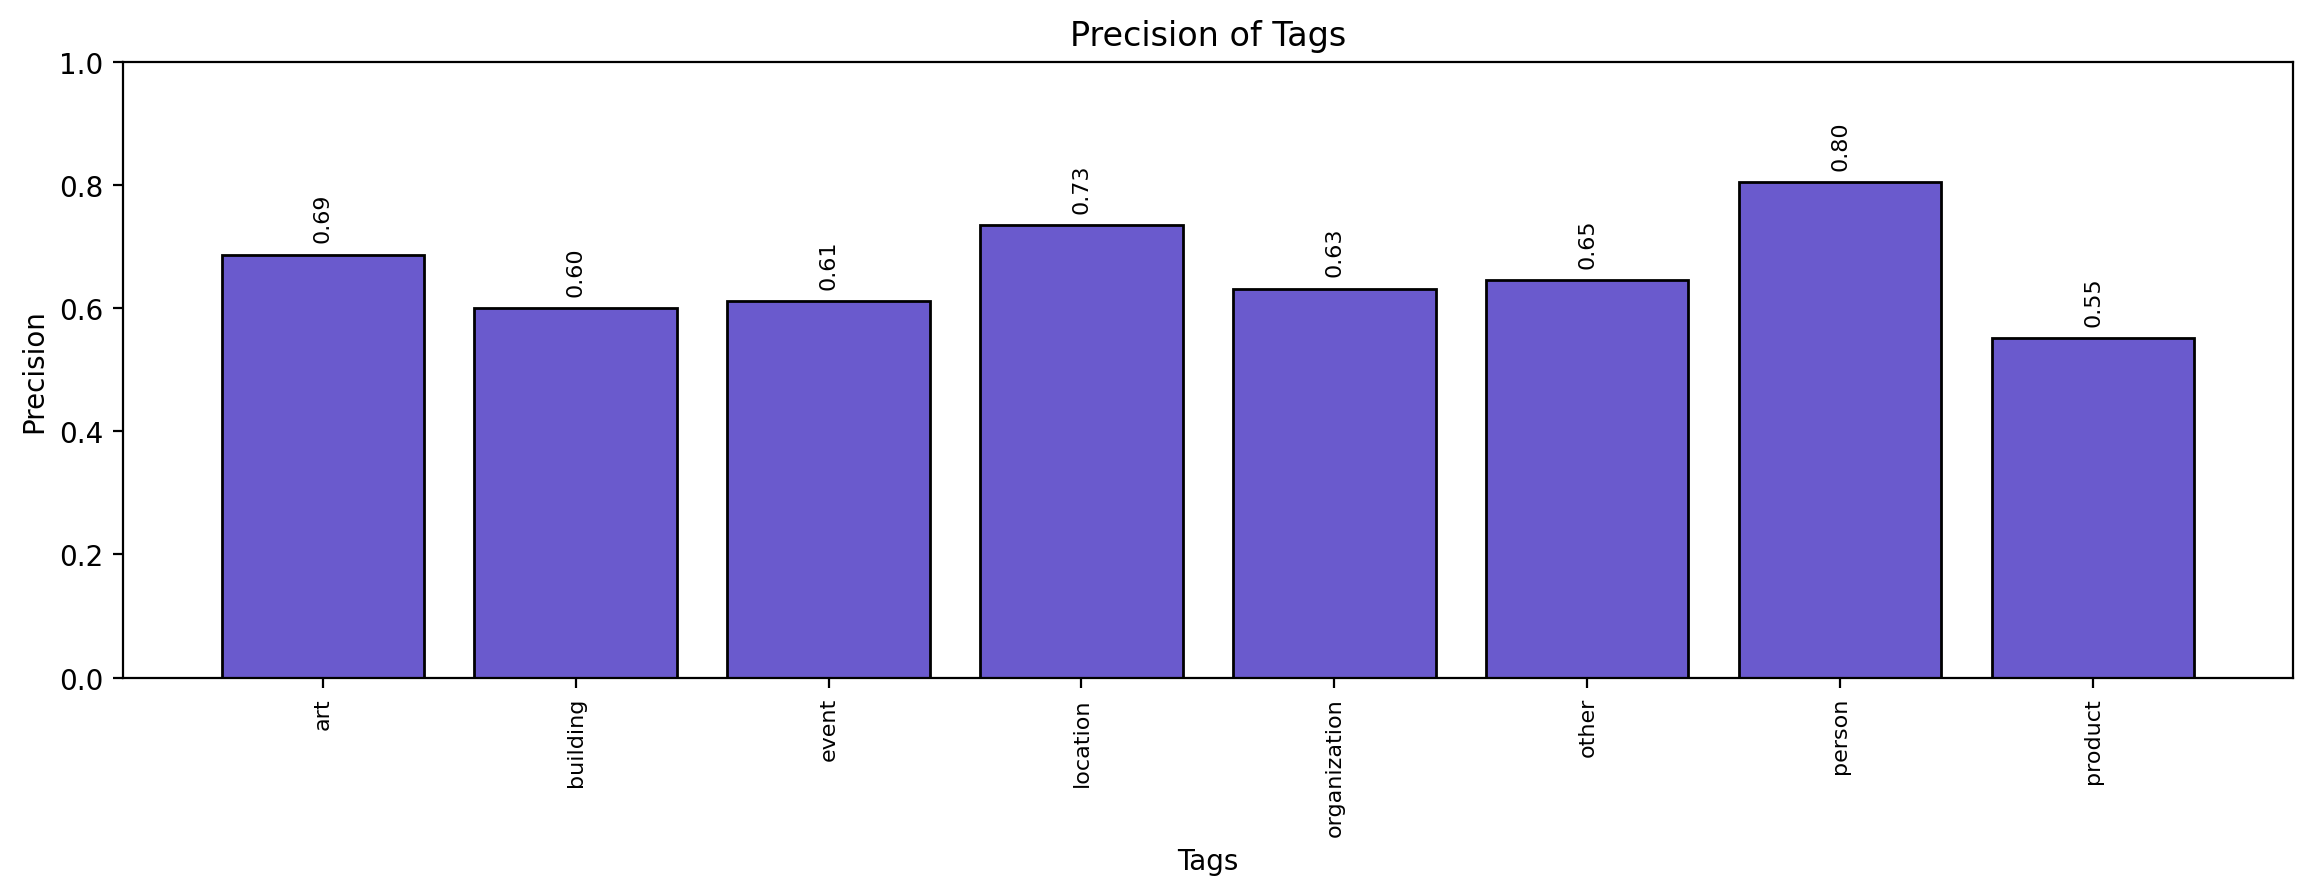

In [12]:
plot_classification_report(
    tag_names=list(TAG2IDX.keys())[2:],
    tag_scores=precision_score(y_true=batch_trues, y_pred=batch_preds, average=None)
)

# Demo

In [13]:
def predict_ner_for_sentence(sentence: str, token2idx: Dict[str, int] = TKN2IDX) -> List[str]:

    input_tokens = [token2idx[token] if token in token2idx else token2idx['UKN'] for token in sentence.split(' ')]
    input_tokens = padding(input_tokens, max_len=config.SEQ_LEN)
    input_tokens = torch.tensor(input_tokens)
    mask = (input_tokens > 0).bool()

    emission_scores = model(input_tokens.unsqueeze(0))
    preds = torch.tensor(model.decode(emission_scores)).squeeze()
    preds = [IDX2TAG[idx] for idx in preds[mask].tolist()]
    preds = io2bio(preds)

    return preds

In [14]:
sentence = "The Mona Lisa is located in Paris and was painted by Leonardo da Vinci."

In [15]:
highlighted_text = highlight_entities(
    tokens=sentence.split(' '), 
    ner_tags=predict_ner_for_sentence(sentence=sentence), 
    font_size=18
)
HTML(highlighted_text)